# How Neural Networks Work

Lets create and run a system per the 1988 paper "How Neural Networks Work" which can be found at https://papers.nips.cc/paper/59-how-neural-nets-work.pdf

Lets train a neural network to solve the xor problem.

The following specifies the XOR truth table. The function writes it to a data file on disk for training.

In [147]:
import numpy as np
import struct

truthTable = [[0.1, 0.1], 0.1, 
              [0.1, 0.9], 0.9, 
              [0.9, 0.1], 0.9, 
              [0.9, 0.9], 0.1]

def farboptWriteData(filename, examples, nInput, nOutput):
    array = np.array(np.hstack(examples), dtype=float)
    exLen = int(nInput+nOutput)
    nExamples = int(int(array.size)/exLen)
    
    fn = open(filename,'wb')
    fn.write(bytearray(struct.pack('i',int(nInput))))
    fn.write(bytearray(struct.pack('i',int(nOutput))))
    fn.write(bytearray(struct.pack('i',int(nExamples))))
    
    index = 0
    for i in range(0,nExamples):
        for j in range(0, nInput+nOutput):
            fn.write(bytearray(struct.pack('f',array[index])))
            index = index + 1
    
    fn.close()
    
farboptWriteData('train.dat', truthTable,2,1)


We want to train using Tanh using the data in the file train.dat. 

Note the configuration definitions written to the FcnOfInterest_config.h file. The script BUILD.python.module.sh builds the python callable C++ predict code.

In [148]:
f=open("FcnOfInterest_config.h","w")
f.write("#define GFCN Tanh_G\n")
f.close()

In [149]:
import subprocess
output = subprocess.getoutput(['make -j'])
output = subprocess.getoutput(['sh BUILD.python.module.sh'])

output = subprocess.getoutput(['rm -f param.dat'])
output = subprocess.getoutput(['./nloptTrain.x -p param.dat -d train.dat -t 60'])
print(output)

training data in: train.dat
using and/or writing params to: param.dat
OMP_NUM_THREADS 24
nInput 2 nOutput 1 nExamples 4 in datafile (train.dat)
*******************
Objective Function: Least Means Squared
Function of Interest: XOR function with G() tanh()
Number params 7
Max Runtime is 60 seconds
Using NLOPT_LD_LBFGS
	Optimization Time 0.0878895
	found minimum 1.690314555e-14 ret 1
RUNTIME Info (4 examples)
	DataLoadtime 0.00523818 seconds
	AveObjTime 1.40213e-05, countObjFunc 22, totalObjTime 0.000294448
	Estimated Flops myFunc 20,average GFlop/s 0.00570558 nFuncCalls 22
	Estimated maximum GFlop/s 0.0144066, minimum GFLop/s 0.00879305
	AveGradTime 0.00370985, nGradCalls 22, totalGradTime 0.0816167
	nFuncCalls/nGradCalls 1.00


Let's look at the output by calling the C++ prediction function using the model parameters from the training run. 

In [150]:
input = truthTable[0::2]
known = truthTable[1::2]

from farbopt import PyPredFcn
Cfcn =PyPredFcn(b'param.dat')

for i in range(0,len(input)):
    pred = Cfcn.predict(input[i])
    print('known ', known[i], " pred %3.1f" % pred[0])
      

known  0.1  pred 0.1
known  0.9  pred 0.9
known  0.9  pred 0.9
known  0.1  pred 0.1


Now lets look at the surface fit by the neural network. Note with two inputs and 1 output we can create a 3D surface. The neural network predicts by calculating the value on this surface given the input values.

Continuity of the surface means the neural network interpolates between known points. If needed the ANN can extrapolate to unknown point - again because the surface is continious.

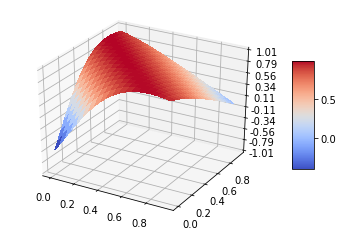

In [152]:
'''
======================
3D surface of XOR (color map)
======================

'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0., 1.0, 0.05)
Y = np.arange(0., 1.0, 0.05)
X, Y = np.meshgrid(X, Y)

input = np.column_stack((X.ravel(),Y.ravel()))

Z=[]
for I in input:
    p = Cfcn.predict(np.array(I))[0]
    Z = np.append(Z,p)

Z = np.reshape(Z,(len(X),len(Y)))

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()